![Parked car](car.jpg)

Insurance companies invest a lot of [time and money](https://www.accenture.com/_acnmedia/pdf-84/accenture-machine-leaning-insurance.pdf) into optimizing their pricing and accurately estimating the likelihood that customers will make a claim. In many countries, insurance is a legal requirement to have car insurance in order to drive a vehicle on public roads, so the market is very large!

Knowing all of this, On the Road car insurance has requested your services in building a model to predict whether a customer will make a claim on their insurance during the policy period. As they have very little expertise and infrastructure for deploying and monitoring machine learning models, they've asked you to use simple Logistic Regression, identifying the single feature that results in the best-performing model, as measured by accuracy.

They have supplied you with their customer data as a csv file called `car_insurance.csv`, along with a table (below) detailing the column names and descriptions below.

## The dataset

| Column | Description |
|--------|-------------|
| `id` | Unique client identifier |
| `age` | Client's age: <br> <ul><li>`0`: 16-25</li><li>`1`: 26-39</li><li>`2`: 40-64</li><li>`3`: 65+</li></ul> |
| `gender` | Client's gender: <br> <ul><li>`0`: Female</li><li>`1`: Male</li></ul> |
| `driving_experience` | Years the client has been driving: <br> <ul><li>`0`: 0-9</li><li>`1`: 10-19</li><li>`2`: 20-29</li><li>`3`: 30+</li></ul> |
| `education` | Client's level of education: <br> <ul><li>`0`: No education</li><li>`1`: High school</li><li>`2`: University</li></ul> |
| `income` | Client's income level: <br> <ul><li>`0`: Poverty</li><li>`1`: Working class</li><li>`2`: Middle class</li><li>`3`: Upper class</li></ul> |
| `credit_score` | Client's credit score (between zero and one) |
| `vehicle_ownership` | Client's vehicle ownership status: <br><ul><li>`0`: Does not own their vehilce (paying off finance)</li><li>`1`: Owns their vehicle</li></ul> |
| `vehcile_year` | Year of vehicle registration: <br><ul><li>`0`: Before 2015</li><li>`1`: 2015 or later</li></ul> |
| `married` | Client's marital status: <br><ul><li>`0`: Not married</li><li>`1`: Married</li></ul> |
| `children` | Client's number of children |
| `postal_code` | Client's postal code | 
| `annual_mileage` | Number of miles driven by the client each year |
| `vehicle_type` | Type of car: <br> <ul><li>`0`: Sedan</li><li>`1`: Sports car</li></ul> |
| `speeding_violations` | Total number of speeding violations received by the client | 
| `duis` | Number of times the client has been caught driving under the influence of alcohol |
| `past_accidents` | Total number of previous accidents the client has been involved in |
| `outcome` | Whether the client made a claim on their car insurance (response variable): <br><ul><li>`0`: No claim</li><li>`1`: Made a claim</li></ul> |

In [100]:
# Import required libraries
install.packages(c("visdat"), verbose = FALSE)
library(readr, verbose = FALSE)
library(dplyr, verbose = FALSE)
library(glue, verbose = FALSE)
library(yardstick, verbose = FALSE)
library(tidyr, verbose = FALSE)
library(purrr, verbose = FALSE)
library(ggplot2, verbose = FALSE)
library(visdat, verbose = FALSE)
library(broom, verbose = FALSE)
library(yardstick, verbose = FALSE)
#library(cluster) # for gower similarity and pam
#library(Rtsne) # for t-SNE plot

Installing package into ‘/home/repl/renv/library/R-4.2/x86_64-pc-linux-gnu’
(as ‘lib’ is unspecified)



In [101]:
# Import the dataset but drop the id column
car_insurance = read_csv("car_insurance.csv", show_col_types = FALSE, col_select = -c("id"))

# Exploration
First, we'll explore any missing value in the dataset

In [102]:
# Dataset dimension
dim(car_insurance)
# Observing ranges and missing values
summary(car_insurance)

[1] 10000    18

      age           gender           race        driving_experience
 Min.   :0.00   Min.   :0.000   Min.   :0.0000   Min.   :0.000     
 1st Qu.:1.00   1st Qu.:0.000   1st Qu.:1.0000   1st Qu.:0.000     
 Median :1.00   Median :0.000   Median :1.0000   Median :1.000     
 Mean   :1.49   Mean   :0.499   Mean   :0.9012   Mean   :1.069     
 3rd Qu.:2.00   3rd Qu.:1.000   3rd Qu.:1.0000   3rd Qu.:2.000     
 Max.   :3.00   Max.   :1.000   Max.   :1.0000   Max.   :3.000     
                                                                   
   education        income     credit_score    vehicle_ownership
 Min.   :0.00   Min.   :0.0   Min.   :0.0534   Min.   :0.000    
 1st Qu.:2.00   1st Qu.:1.0   1st Qu.:0.4172   1st Qu.:0.000    
 Median :2.00   Median :2.0   Median :0.5250   Median :1.000    
 Mean   :2.01   Mean   :1.9   Mean   :0.5158   Mean   :0.697    
 3rd Qu.:3.00   3rd Qu.:3.0   3rd Qu.:0.6183   3rd Qu.:1.000    
 Max.   :3.00   Max.   :3.0   Max.   :0.9608   Max.   :1.000    
 

As we can see, `credit_score` and `annual_mileage` have similar amount of missing values. Let's investigate this missingness a little deeper.

## Missing values imputation

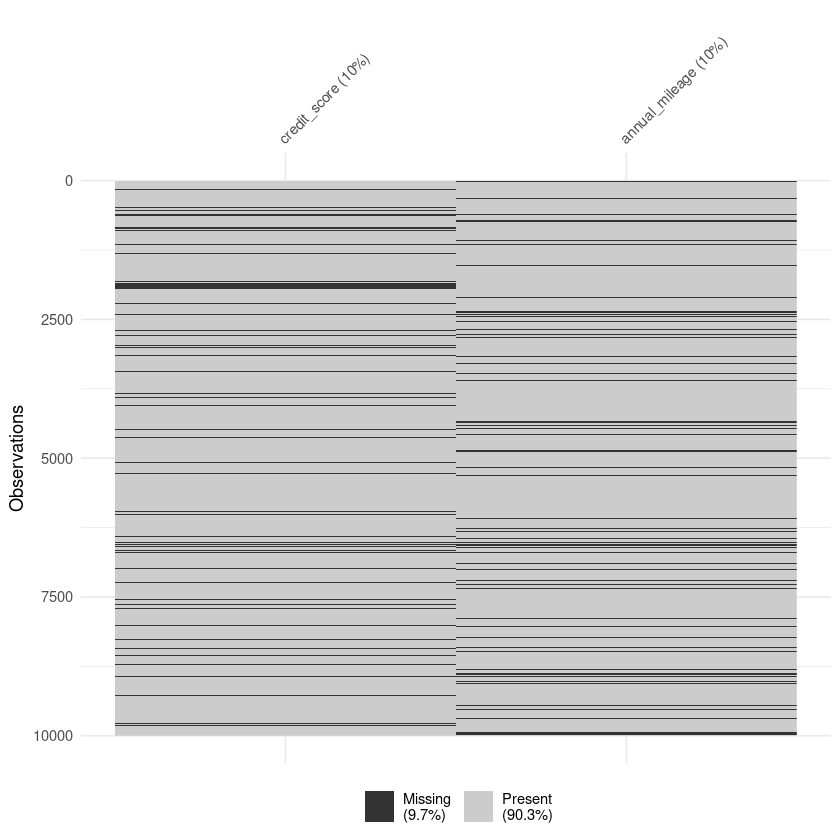

In [103]:
vis_miss(car_insurance[,c("credit_score", "annual_mileage")])


There is no evident relationship between the missingness of these variables. Now let's see if another variable has something to do with this.

In [104]:
# Comparing present and missing values for credit_score
car_insurance %>%
	mutate(miss_credit_score = is.na(credit_score)) %>%
	group_by(miss_credit_score) %>%
	summarise_all(mean, na.rm = TRUE)

# Comparing present and missing values for annual_mileage
car_insurance %>%
	mutate(miss_annual_mileage = is.na(annual_mileage)) %>%
	group_by(miss_annual_mileage) %>%
	summarise_all(mean, na.rm = TRUE)

miss_credit_score,age,gender,race,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,1.495121,0.5003327,0.8996452,1.070858,2.013750,1.905855,0.5158128,0.6992681,0.3053892,0.5003327,0.6889554,19796.91,11693.46,0.04746063,1.480927,0.2388556,1.057108,0.3137059
TRUE,1.437882,0.4867617,0.9154786,1.054990,1.973523,1.842159,NaN,0.6761711,0.2841141,0.4786151,0.6873727,20485.68,11729.31,0.04989817,1.501018,0.2423625,1.048880,0.3095723


miss_annual_mileage,age,gender,race,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,1.493310,0.4978436,0.8997014,1.075528,2.014265,1.905341,0.5163677,0.6964503,0.3054296,0.4979542,0.6884883,19787.98,11697,0.04810351,1.490545,0.2407387,1.0660179,0.3107376
TRUE,1.453501,0.5099269,0.9153605,1.010449,1.967607,1.845350,0.5106091,0.7021944,0.2831766,0.5005225,0.6917450,20588.10,NaN,0.04388715,1.410658,0.2246604,0.9644723,0.3375131


This brief analysis allows us to conclude that there is no visible factor among the observed variables related to the missing values of `credit_score` and `annual_mileage`.
So, given that the missing values stand for about 10% of the dataset, we'll fill them in using the information of some of the variables in the dataset.

Given that most variables are categorical, we will impute the missing values per combination of the categories and get the median of `credit_score` and `annual_mileage` for each of them. However, to avoid finding a single combination which has no value on either credit score or annual mileage, we'll tailor the combinations to intuitively relevant variables for each the targets. For example, for credit score, `age`, `income`, `married` and `children` could create relevant strata. While for annual mileage, `vehicle_ownership`, `vehicle_year` and `vehicle_type` could create more suitable strata.

In [105]:
# Categorical variables to create relevant strata for credit_score
catvars_credit_score = c('age', 'income', 'married', 'children')

# Categorical variables to create relevant strata for annual_mileage
catvars_annual_mileage = c('vehicle_ownership', 'vehicle_year', 'vehicle_type')

# Getting all combinations from the categorical variables for credit_score
strata_credit_score = car_insurance %>%
	select(all_of(catvars_credit_score)) %>%
	unique() %>% 
	# Creating a combination id
	mutate(comb_id_credit = seq(1:nrow(.)))
glimpse(strata_credit_score)

# Getting all combinations from the categorical variables for credit_score
strata_annual_mileage = car_insurance %>%
	select(all_of(catvars_annual_mileage)) %>%
	unique() %>% 
	# Creating a combination id
	mutate(comb_id_annual = seq(1:nrow(.)))
glimpse(strata_annual_mileage)

Rows: 62
Columns: 5
$ age            <dbl> 3, 0, 0, 0, 1, 2, 3, 1, 2, 3, 2, 0, 1, 1, 0, 1, 0, 2, 1…
$ income         <dbl> 3, 0, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 2, 3, 0, 3, 2, 0, 2…
$ married        <dbl> 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1…
$ children       <dbl> 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0…
$ comb_id_credit <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, …
Rows: 8
Columns: 4
$ vehicle_ownership <dbl> 1, 0, 1, 0, 1, 0, 0, 1
$ vehicle_year      <dbl> 1, 0, 0, 1, 0, 1, 0, 1
$ vehicle_type      <dbl> 0, 0, 0, 0, 1, 1, 1, 1
$ comb_id_annual    <int> 1, 2, 3, 4, 5, 6, 7, 8


In [106]:
# Left join to merge the strata datasets with the main dataset
car_insurance_merged = car_insurance %>%
	left_join(strata_credit_score, by = catvars_credit_score) %>%
	left_join(strata_annual_mileage, by = catvars_annual_mileage)
glimpse(car_insurance_merged)

# Calculating the credit_score median per stratum
credit_score_fill = car_insurance_merged %>%
			aggregate(credit_score ~ comb_id_credit, data = ., median, na.rm = TRUE)
dim(credit_score_fill)
# Checking for missing values
sum(is.na(credit_score_fill))

# Calculating the annual_mileage median per stratum
annual_mileage_fill = car_insurance_merged %>%
			aggregate(annual_mileage ~ comb_id_annual, data = ., median, na.rm = TRUE)
dim(annual_mileage_fill)
# Checking for missing values
sum(is.na(annual_mileage_fill))

# Merging all datasets
car_insurance_filled = car_insurance_merged %>%
	left_join(credit_score_fill, by = "comb_id_credit", suffix = c("", "_median")) %>%
	left_join(annual_mileage_fill, by = "comb_id_annual", suffix = c("", "_median")) %>%
	mutate(credit_score_filled = ifelse(is.na(credit_score), credit_score_median, credit_score),
		  annual_mileage_filled = ifelse(is.na(annual_mileage), annual_mileage_median, annual_mileage))

summary(car_insurance_filled)

Rows: 10,000
Columns: 20
$ age                 <dbl> 3, 0, 0, 0, 1, 2, 3, 1, 2, 2, 3, 3, 2, 0, 1, 1, 3,…
$ gender              <dbl> 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,…
$ race                <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ driving_experience  <dbl> 0, 0, 0, 0, 1, 2, 3, 0, 2, 0, 3, 3, 2, 0, 1, 0, 3,…
$ education           <dbl> 2, 0, 2, 3, 0, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 3,…
$ income              <dbl> 3, 0, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 2, 3, 3,…
$ credit_score        <dbl> 0.6290273, 0.3577571, 0.4931458, 0.2060129, 0.3883…
$ vehicle_ownership   <dbl> 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,…
$ vehicle_year        <dbl> 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,…
$ married             <dbl> 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,…
$ children            <dbl> 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,…
$ postal_code         <dbl> 10238, 10238, 10238, 32765, 32765, 10238, 10238, 1…
$ annual_mileag

[1] 62  2

[1] 0

[1] 8 2

[1] 0

      age           gender           race        driving_experience
 Min.   :0.00   Min.   :0.000   Min.   :0.0000   Min.   :0.000     
 1st Qu.:1.00   1st Qu.:0.000   1st Qu.:1.0000   1st Qu.:0.000     
 Median :1.00   Median :0.000   Median :1.0000   Median :1.000     
 Mean   :1.49   Mean   :0.499   Mean   :0.9012   Mean   :1.069     
 3rd Qu.:2.00   3rd Qu.:1.000   3rd Qu.:1.0000   3rd Qu.:2.000     
 Max.   :3.00   Max.   :1.000   Max.   :1.0000   Max.   :3.000     
                                                                   
   education        income     credit_score    vehicle_ownership
 Min.   :0.00   Min.   :0.0   Min.   :0.0534   Min.   :0.000    
 1st Qu.:2.00   1st Qu.:1.0   1st Qu.:0.4172   1st Qu.:0.000    
 Median :2.00   Median :2.0   Median :0.5250   Median :1.000    
 Mean   :2.01   Mean   :1.9   Mean   :0.5158   Mean   :0.697    
 3rd Qu.:3.00   3rd Qu.:3.0   3rd Qu.:0.6183   3rd Qu.:1.000    
 Max.   :3.00   Max.   :3.0   Max.   :0.9608   Max.   :1.000    
 

## Finding the best predictor
In order to model the probability that the client have made a claim on their car insurance, we'll use simple logistic regression. For that purpose, we'll find the feature with the best predictive performance for a car insurance claim.

In [107]:
# Selecting the variables to assess simple logistic regressions
dflogit = car_insurance_filled %>%
	select(-c(credit_score, annual_mileage, comb_id_credit, comb_id_annual, credit_score_median, annual_mileage_median)) %>%
	rename(credit_score = credit_score_filled, annual_mileage = annual_mileage_filled) %>%
# converting categorical variables in factor type
	mutate_at(vars('age', 'gender', 'race', 'driving_experience', 'education', 'income', 'vehicle_ownership', 'vehicle_year', 'married', 'vehicle_type', 'postal_code'), factor)
glimpse(dflogit)

Rows: 10,000
Columns: 18
$ age                 <fct> 3, 0, 0, 0, 1, 2, 3, 1, 2, 2, 3, 3, 2, 0, 1, 1, 3,…
$ gender              <fct> 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,…
$ race                <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ driving_experience  <fct> 0, 0, 0, 0, 1, 2, 3, 0, 2, 0, 3, 3, 2, 0, 1, 0, 3,…
$ education           <fct> 2, 0, 2, 3, 0, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 3,…
$ income              <fct> 3, 0, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 2, 3, 3,…
$ vehicle_ownership   <fct> 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,…
$ vehicle_year        <fct> 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,…
$ married             <fct> 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,…
$ children            <dbl> 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,…
$ postal_code         <fct> 10238, 10238, 10238, 32765, 32765, 10238, 10238, 1…
$ vehicle_type        <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ speeding_viol

To assess the models we'll split the initial sample into training (70%) and test (30%). We'll use random sampling technique to split the samples, this way, we'll ensure similar distributions across all the samples.

In [108]:
# getting the predictors names
pred = names(dflogit)[!grepl('outcome', names(dflogit))] 
# splitting the sample into training and test
set.seed(1267) # setting the seed to ensure reproducibility
# Training sample: 70% of observations
dftrain = dflogit %>%
	slice_sample(n = 7000)
# Test sample: remaining 30% of observations
dftest = dflogit %>%
	filter(!(rownames(dflogit) %in% rownames(dftrain)))

# Checking that proportions of outcome categories are similar among the samples
prop.table(table(dflogit$outcome))
prop.table(table(dftrain$outcome))
prop.table(table(dftest$outcome))



     0      1 
0.6867 0.3133 


    0     1 
0.685 0.315 


        0         1 
0.6906667 0.3093333 

We'll use accuracy as a metric to assess each feature relevance.

In [109]:
# simple logistic regression
model = glm(as.formula(paste0('outcome ~ ', pred[1])), data = dftrain, family = binomial)
summary_model = summary(model)
# coefficients
summary_coeffs = summary_model$coefficients

# testing model in the training sample
actual_trainvalues = dftrain$outcome
predicted_trainvalues = round(fitted(model))
# computing accuracy
outcomes_train = table(predicted_trainvalues, actual_trainvalues)
accuracy_train = round((outcomes_train["0","0"] + outcomes_train["1","1"])/nrow(dftrain),3)
# testing model in the test sample
actual_testvalues = dftest$outcome
predicted_testvalues = round(predict(model, dftest, type = "response"))
# confussion matrix
outcomes_test = table(predicted_testvalues, actual_testvalues)
accuracy_test = round((outcomes_test["0","0"] + outcomes_test["1","1"])/nrow(dftest),3)

results_model = as_tibble(summary_coeffs) %>%
	mutate(variable = rownames(summary_coeffs), accuracy_train = accuracy_train, accuracy_test = accuracy_test, model_id = 1, feature = pred[1]) %>%
	relocate(any_of(c("model_id", "feature", "variable")))

# continue assessing other features
for (i in 2:length(pred)) {
	#i = 5
	model = glm(as.formula(paste0('outcome ~ ', pred[i])), data = dftrain, family = binomial)
	summary_model = summary(model)
	summary_coeffs = summary_model$coefficients
	
	# testing model in the training sample
	actual_trainvalues = dftrain$outcome
	predicted_trainvalues = round(fitted(model))
	# Computing accuracy for training sample
	accuracy_train = round((length(which(actual_trainvalues == 0 & predicted_trainvalues == 0)) + length(which(actual_trainvalues == 1 & predicted_trainvalues == 1)))/nrow(dftrain),3)
	
	# testing model in the test sample
	actual_testvalues = dftest$outcome
	predicted_testvalues = round(predict(model, dftest, type = "response"))
	# computing accuracy for test sample
	accuracy_test = round((length(which(actual_testvalues == 0 & predicted_testvalues == 0)) + length(which(actual_testvalues == 1 & predicted_testvalues == 1)))/nrow(dftrain),3)

	# storing every important result in a tibble
results_model0 = as_tibble(summary_coeffs) %>%
		mutate(variable = rownames(summary_coeffs), accuracy_train = accuracy_train, accuracy_test = 	accuracy_test, model_id = i, feature = pred[i]) %>%
	relocate(any_of(c("model_id", "feature", "variable")))

results_model0

results_model = rbind(results_model, results_model0)
}

results_model


model_id,feature,variable,Estimate,Std. Error,z value,Pr(>|z|),accuracy_train,accuracy_test
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,age,(Intercept),0.9396923474,5.918732e-02,15.8765822,9.205988e-57,0.773,0.773
1,age,age1,-1.5936188149,7.477333e-02,-21.3126644,8.662299e-101,0.773,0.773
1,age,age2,-2.6401294688,8.505145e-02,-31.0415560,1.483200e-211,0.773,0.773
1,age,age3,-3.1103320807,1.060141e-01,-29.3388546,3.315226e-189,0.773,0.773
2,gender,(Intercept),-1.0306249477,3.834018e-02,-26.8810680,3.656583e-159,0.685,0.296
2,gender,gender1,0.4869591778,5.198941e-02,9.3665068,7.497281e-21,0.685,0.296
3,race,(Intercept),-0.7241918022,8.177963e-02,-8.8554060,8.337979e-19,0.685,0.296
3,race,race1,-0.0583802131,8.615548e-02,-0.6776146,4.980161e-01,0.685,0.296
4,driving_experience,(Intercept),0.5514966635,4.182420e-02,13.1860645,1.055534e-39,0.780,0.330


The results displayed in the table show that `driving_experience` is the best feature for the simple model since the accuracy in the training sample it gets is about 78%. We can observe that the most experienced a driver is, it's less likely that the customer makes a claim on their insurance during the policy period.

In [110]:
best_feature_df0 = results_model %>%
	select(feature, accuracy_train) %>%
	group_by(feature) %>%
	summarise(accuracy = max(accuracy_train)) %>%
	arrange(desc(accuracy)) %>%
	top_n(n = 1) %>%
	rename(best_feature = feature,
		  best_accuracy = accuracy)
best_feature_df0

Selecting by accuracy


best_feature,best_accuracy
<chr>,<dbl>
driving_experience,0.78


In [111]:
best_feature_df = data.frame(best_feature = best_feature_df0$best_feature,
							best_accuracy = best_feature_df0$best_accuracy)

In [112]:
# assessing all the features individually in the training sample
simple_logits_train = purrr::map_dfr(1:length(pred), function(i) data.frame(model = i, tidy(glm(as.formula(paste0('outcome ~ ', pred[i])), data = dftrain, family = binomial))))
simple_logits_train

model,term,estimate,std.error,statistic,p.value
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,(Intercept),0.9396923474,5.918732e-02,15.8765822,9.205988e-57
1,age1,-1.5936188149,7.477333e-02,-21.3126644,8.662299e-101
1,age2,-2.6401294688,8.505145e-02,-31.0415560,1.483200e-211
1,age3,-3.1103320807,1.060141e-01,-29.3388546,3.315226e-189
2,(Intercept),-1.0306249477,3.834018e-02,-26.8810680,3.656583e-159
2,gender1,0.4869591778,5.198941e-02,9.3665068,7.497281e-21
3,(Intercept),-0.7241918022,8.177963e-02,-8.8554060,8.337979e-19
3,race1,-0.0583802131,8.615548e-02,-0.6776146,4.980161e-01
4,(Intercept),0.5514966635,4.182420e-02,13.1860645,1.055534e-39
